In [50]:
pip install sklearn

In [66]:
import numpy as np # linear algebra
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt
#import seaborn as sns # Plotting library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.datasets import load_files
from tensorflow.keras.preprocessing import image
import itertools
from sklearn.metrics import confusion_matrix


In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Assignment_data/FoodImage/train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Assignment_data/FoodImage/test')

In [69]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total images in train folder: ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total images in test folder: ",image_count_test)

Total images in train folder:  407
Total images in test folder:  90


In [70]:
## preparing the dataset

batch_size = 8
img_height = 256
img_width = 256

In [71]:
## listing out all the classes in given dataset

class_names = sorted([item.name for item in data_dir_train.glob('*')][:6])
print(class_names)

['ApplePie', 'BagelSandwich', 'Bibimbop', 'Bread', 'FriedRice', 'Pork']


In [72]:
# Create an ImageDataGenerator and specify the data preprocessing options
data_generator = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
data_generator1 = ImageDataGenerator(rescale=1.0/255)

# Use the flow_from_directory function to load and split the data
train_data_generator = data_generator.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=42
)


validation_data_generator = data_generator.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=True,
    subset='validation',
    seed=42
)

test_generator = data_generator1.flow_from_directory(
        data_dir_test,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)


Found 328 images belonging to 6 classes.
Found 79 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


In [73]:
## checking the length of folders

num_train = len(train_data_generator.filenames)
num_valid = len(validation_data_generator.filenames)
num_test = len(test_generator.filenames)

print(num_train, num_valid, num_test)

328 79 90


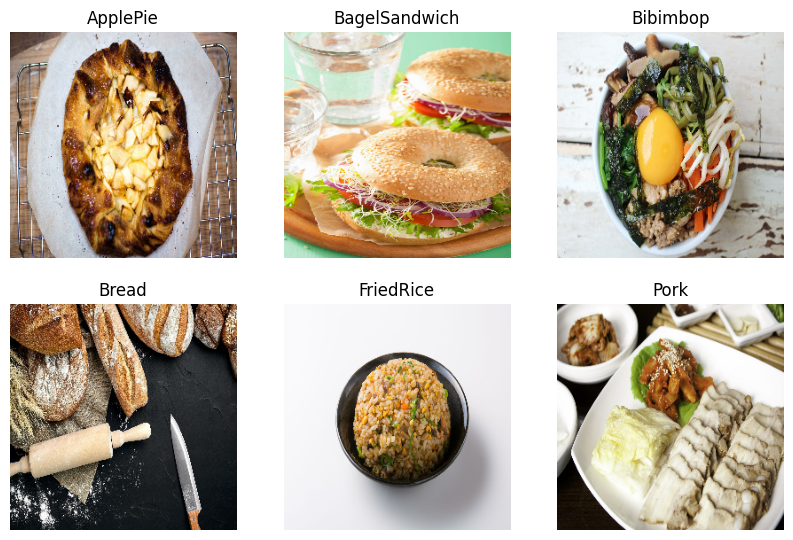

In [29]:
## visualise the data

plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_data_generator.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [74]:
base_model = ResNet50(weights='imagenet', include_top=False)

# adding a global spatial average pooling layer to the ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Adding a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.95)(x)

# Adding dense network that connects 6 classes as output

cnn_model = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=cnn_model)

for layer in base_model.layers:
    layer.trainable = True

In [75]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_7[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [76]:
# compiling the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

In [77]:
# training the model
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Image_classification_food/FoodImage/CNN_model.hdf5', verbose=1,
                               save_best_only=True)

scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8, verbose=1)

early_stopper = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=0, restore_best_weights=True)

history = model.fit(train_data_generator,
                    steps_per_epoch=40,
                    epochs=40,
                    verbose=0,
                    callbacks=[checkpointer, scheduler, early_stopper],
                    validation_data=validation_data_generator,
                    validation_steps=10)


Epoch 1: val_loss improved from inf to 2.30310, saving model to /content/drive/MyDrive/Colab Notebooks/Image_classification_food/FoodImage/CNN_model.hdf5

Epoch 2: val_loss did not improve from 2.30310

Epoch 3: val_loss did not improve from 2.30310

Epoch 4: val_loss did not improve from 2.30310

Epoch 5: val_loss did not improve from 2.30310

Epoch 6: val_loss improved from 2.30310 to 2.29470, saving model to /content/drive/MyDrive/Colab Notebooks/Image_classification_food/FoodImage/CNN_model.hdf5

Epoch 7: val_loss improved from 2.29470 to 1.76890, saving model to /content/drive/MyDrive/Colab Notebooks/Image_classification_food/FoodImage/CNN_model.hdf5

Epoch 8: val_loss did not improve from 1.76890

Epoch 9: val_loss did not improve from 1.76890

Epoch 10: val_loss did not improve from 1.76890

Epoch 11: val_loss did not improve from 1.76890

Epoch 12: val_loss did not improve from 1.76890

Epoch 12: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 13: val

In [78]:
## evaluating the model
model.evaluate(validation_data_generator)

79/79 [==============================] - 6s 71ms/step - loss: 0.2863 - accuracy: 0.9241


[0.28632205724716187, 0.9240506291389465]

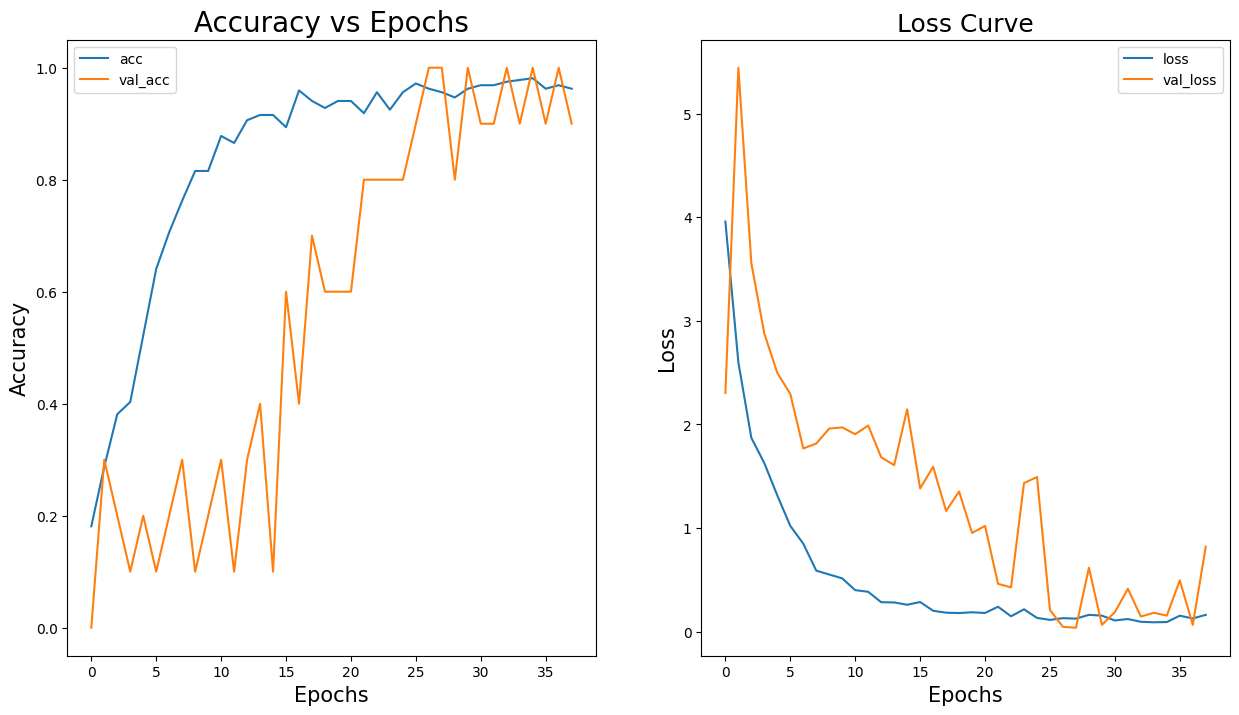

In [79]:
## visualising Accuracy and loss

def model_performance_graphs():

    fig, axes = plt.subplots(1, 2, figsize = (15, 8))

    axes[0].plot(history.epoch, history.history['accuracy'], label = 'acc')
    axes[0].plot(history.epoch, history.history['val_accuracy'], label = 'val_acc')
    axes[0].set_title('Accuracy vs Epochs', fontsize = 20)
    axes[0].set_xlabel('Epochs', fontsize = 15)
    axes[0].set_ylabel('Accuracy', fontsize = 15)
    axes[0].legend()

    axes[1].plot(history.epoch, history.history['loss'], label = 'loss')
    axes[1].plot(history.epoch, history.history['val_loss'], label="val_loss")
    axes[1].set_title("Loss Curve",fontsize=18)
    axes[1].set_xlabel("Epochs",fontsize=15)
    axes[1].set_ylabel("Loss",fontsize=15)
    axes[1].legend()

    plt.show()

model_performance_graphs()

In [80]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(256, 256))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0

    return img_preprocessed

In [81]:
## specify the path in which the trained models needs to be saved
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Image_classification_food/FoodImage/CNN_model.hdf5')

In [87]:
img_path = "/content/drive/MyDrive/Colab Notebooks/Assignment_data/FoodImage/test/Pork/B070220XX_11077.jpg"
img = preprocess_images(img_path)

prediction = loaded_model.predict(img)

predicted_class_index = np.argmax(prediction)

class_labels = ['ApplePie', 'BagelSandwich', 'Bibimbop', 'Bread', 'FriedRice', 'Pork']
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

1/1 [==============================] - 0s 29ms/step
Predicted class: Pork


In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [95]:
predictions_new = loaded_model.predict(x=test_generator, verbose=1)

90/90 [==============================] - 8s 76ms/step


In [110]:
y_true=test_generator.classes
y_pred=np.argmax(predictions_new,axis=1)

In [106]:
cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[14  0  0  0  0  1]
 [ 1 11  0  2  0  1]
 [ 0  0 15  0  0  0]
 [ 1  0  0 13  1  0]
 [ 0  0  0  1 14  0]
 [ 0  0  0  0  0 15]]


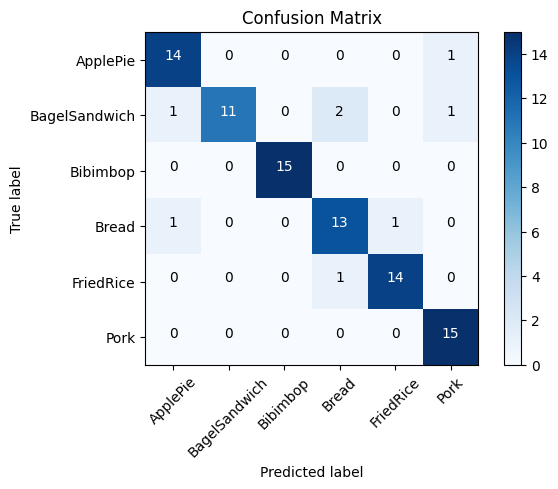

In [116]:
cm_plot_labels = class_labels
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [117]:
## Checking classification report

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_labels))

               precision    recall  f1-score   support

     ApplePie       0.88      0.93      0.90        15
BagelSandwich       1.00      0.73      0.85        15
     Bibimbop       1.00      1.00      1.00        15
        Bread       0.81      0.87      0.84        15
    FriedRice       0.93      0.93      0.93        15
         Pork       0.88      1.00      0.94        15

     accuracy                           0.91        90
    macro avg       0.92      0.91      0.91        90
 weighted avg       0.92      0.91      0.91        90

